# Regression with Assymmetric loss function

1. Feature extraction --> windowing(3 mins), handcrafted features, 
2. Data split
3. Conduct regression with different loss functions
4. Scoring methods :
    MAE
    MBR
    MSE

Note that Composite is Task C and Ziptie is Task H.


Instead of a random split use a predefined split.
In this case use the below subjects in test set :
7, 17, 25 -- Female
24, 14, 12, 08, 30 -- Male

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import sys
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

## Pytorch related
import torch
from torch._C import dtype
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## Scikit related
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy import integrate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import cross_val_score
from scipy.stats import skew
from scipy.stats import norm, kurtosis
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.neighbors import KernelDensity


# tensorflow related
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Append other paths to access 


# Updated helper fucntion made for the new data from formal user study

from helper_functions_user_study_2_0 import get_all_file_paths
from helper_functions_user_study_2_0 import regr_feature_extract_one_segment
from helper_functions_user_study_2_0 import feature_scaling
from helper_functions_user_study_2_0 import regr_segment_time_series
# from helper_functions_user_study import SVR_linear
# from helper_functions_user_study import SVR_poly
# from helper_functions_user_study import SVR_rbf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Prepare Dataframe for Regression Tasks

In [2]:
def __read_csv_drop_unnamed__(csv_path) :
    pd_test = pd.read_csv(csv_path)
    pd_test.columns.str.match("Unnamed")
    pd_test = pd_test.loc[:,~pd_test.columns.str.match("Unnamed")]
    return pd_test


In [3]:
def conv_segment_df (segment) :
    df = pd.DataFrame(segment, columns=[
        ['Time',
 'HR_Processed',
 'HR',
 'HRV',
 'RR',
 'RRSQI',
 'ECGSQI',
 'ECG',
 'acc_X',
 'acc_Y',
 'acc_Z',
 'Temperature',
 'IMU_1_ax_g_',
 'IMU_1_ay_g_',
 'IMU_1_az_g_',
 'IMU_1_gx_dps_',
 'IMU_1_gy_dps_',
 'IMU_1_gz_dps_',
 'IMU_2_ax_g_',
 'IMU_2_ay_g_',
 'IMU_2_az_g_',
 'IMU_2_gx_dps_',
 'IMU_2_gy_dps_',
 'IMU_2_gz_dps_',
 'IMU_3_ax_g_',
 'IMU_3_ay_g_',
 'IMU_3_az_g_',
 'IMU_3_gx_dps_',
 'IMU_3_gy_dps_',
 'IMU_3_gz_dps_',
 'IMU_4_ax_g_',
 'IMU_4_ay_g_',
 'IMU_4_az_g_',
 'IMU_4_gx_dps_',
 'IMU_4_gy_dps_',
 'IMU_4_gz_dps_',
 'IMU_5_ax_g_',
 'IMU_5_ay_g_',
 'IMU_5_az_g_',
 'IMU_5_gx_dps_',
 'IMU_5_gy_dps_',
 'IMU_5_gz_dps_',
 'Physical Fatigue - Initial',
 'Physical Fatigue - Final',
 'Mental Fatigue - Initial',
 'Mental Fatigue - Final',
 'Performance rating',
 'Age',
 'Weight',
 'Height',
 'Weights added',
 'Gender']
    ])
    return df  
def file_segment_features(test_seg) :
#    print('Inside segment features') 
   # Give segmented 3D array to this --> Features dataframe
   test_one_seg = conv_segment_df(test_seg[0])
   features_df = regr_feature_extract_one_segment(test_one_seg)
   #features_df.head()
   for i in range(1, np.shape(test_seg)[0]) :
    # print('===============================================================I am in segment ', i)
    temp_seg = conv_segment_df(test_seg[i])
    df = regr_feature_extract_one_segment(temp_seg)
    features_df = features_df.append(df)
    
   return features_df 

In [4]:
# Get all Composite Training Files
window_size = 360 ## 120 is one min
source_data_path_composite = 'composite_train/'
# this function is to get all the interpolated and segmented data
folder_list_composite = os.listdir(source_data_path_composite)
composite_file_names = get_all_file_paths(source_data_path_composite, folder_list_composite)

composite_main_dataframe = pd.DataFrame(__read_csv_drop_unnamed__(composite_file_names[0]))
test_seg_0 = regr_segment_time_series(window_size, composite_main_dataframe)
composite_main_dataframe = file_segment_features(test_seg_0)
for i in range(1,len(composite_file_names)):
  data = __read_csv_drop_unnamed__(composite_file_names[i])
  if (len(data) < window_size) :
    pass
  else :
    test_seg = regr_segment_time_series(window_size,data)
    features_df = file_segment_features(test_seg)
    composite_main_dataframe = composite_main_dataframe.append(features_df)


/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# Get all composite Testing Files
source_data_path_composite_test = 'composite_test/'
# this function is to get all the interpolated and segmented data
folder_list_composite_test = os.listdir(source_data_path_composite_test)
composite_file_names_test = get_all_file_paths(source_data_path_composite_test, folder_list_composite_test)

composite_main_dataframe_test = pd.DataFrame(__read_csv_drop_unnamed__(composite_file_names_test[0]))
test_seg_0 = regr_segment_time_series(window_size, composite_main_dataframe_test)
composite_main_dataframe_test = file_segment_features(test_seg_0)
for i in range(1,len(composite_file_names_test)):
  data = __read_csv_drop_unnamed__(composite_file_names_test[i])
  if (len(data) < window_size) :
    pass
  else :
    test_seg = regr_segment_time_series(window_size,data)
    features_df = file_segment_features(test_seg)
    composite_main_dataframe_test = composite_main_dataframe_test.append(features_df)

In [6]:
np.shape(composite_main_dataframe_test)

(69, 50)

In [7]:
# Get ziptie training files
source_data_path_ziptie = 'ziptie_train'
folder_list_ziptie = os.listdir(source_data_path_ziptie)
ziptie_file_names = get_all_file_paths(source_data_path_ziptie, folder_list_ziptie)

ziptie_main_dataframe = pd.DataFrame(__read_csv_drop_unnamed__(ziptie_file_names[0]))
test_seg_0 = regr_segment_time_series(window_size, ziptie_main_dataframe)
ziptie_main_dataframe = file_segment_features(test_seg_0)
for i in range(1,len(ziptie_file_names)):
  data = __read_csv_drop_unnamed__(ziptie_file_names[i])
  if (len(data) < window_size) :
    pass
  else :
    test_seg = regr_segment_time_series(window_size,data)
    features_df = file_segment_features(test_seg)
    ziptie_main_dataframe = ziptie_main_dataframe.append(features_df)

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/numpy/

In [8]:
# Get ziptie testing files
source_data_path_ziptie_test = 'ziptie_test/'
folder_list_ziptie_test = os.listdir(source_data_path_ziptie_test)
ziptie_file_names = get_all_file_paths(source_data_path_ziptie_test, folder_list_ziptie_test)

ziptie_main_dataframe_test = pd.DataFrame(__read_csv_drop_unnamed__(ziptie_file_names[0]))
test_seg_0 = regr_segment_time_series(window_size, ziptie_main_dataframe_test)
ziptie_main_dataframe_test = file_segment_features(test_seg_0)
for i in range(1,len(ziptie_file_names)):
  data = __read_csv_drop_unnamed__(ziptie_file_names[i])
  if (len(data) < window_size) :
    pass
  else :
    test_seg = regr_segment_time_series(window_size,data)
    features_df = file_segment_features(test_seg)
    ziptie_main_dataframe_test = ziptie_main_dataframe_test.append(features_df)

## Drop rows with 0 HR

In [9]:
composite_main_dataframe = composite_main_dataframe.loc[~((composite_main_dataframe['max_hr'] == 0))]
ziptie_main_dataframe = ziptie_main_dataframe.loc[~((ziptie_main_dataframe['max_hr'] == 0))]
combined_dataframe = ziptie_main_dataframe
combined_dataframe = combined_dataframe.append(composite_main_dataframe)

In [10]:
composite_main_dataframe_test = composite_main_dataframe_test.loc[~((composite_main_dataframe_test['max_hr'] == 0))]
ziptie_main_dataframe_test = ziptie_main_dataframe_test.loc[~((ziptie_main_dataframe_test['max_hr'] == 0))]
combined_dataframe_test = ziptie_main_dataframe_test
combined_dataframe_test = combined_dataframe_test.append(composite_main_dataframe_test)

In [11]:
## Drop duration feature
composite_main_dataframe = composite_main_dataframe.drop(['duration'], axis='columns')
ziptie_main_dataframe    = ziptie_main_dataframe.drop(['duration'], axis='columns')
combined_dataframe       = combined_dataframe.drop(['duration'], axis='columns')


composite_main_dataframe_test = composite_main_dataframe_test.drop(['duration'], axis='columns')
ziptie_main_dataframe_test    = ziptie_main_dataframe_test.drop(['duration'], axis='columns')
combined_dataframe_test       = combined_dataframe_test.drop(['duration'], axis='columns')

# Get ready for training

In [12]:
## Scale the dataset
df_scaled_combined = feature_scaling(0,10, combined_dataframe)
df_scaled_composite = feature_scaling(0,10, composite_main_dataframe)
df_scaled_ziptie = feature_scaling(0,10, ziptie_main_dataframe)

## Get the Testing dataframe ready

In [13]:
## Scale the dataset
df_scaled_combined_test = feature_scaling(0,10, combined_dataframe_test)
df_scaled_composite_test = feature_scaling(0,10, composite_main_dataframe_test)
df_scaled_ziptie_test = feature_scaling(0,10, ziptie_main_dataframe_test)

## Training only Composite Task

In [14]:
## Update Novemebr 14 :: Use fixed test set for all tasks
X_train = df_scaled_composite.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_train = composite_main_dataframe['final_fatigue'] ## Used non-scaled version for target

X_test = df_scaled_composite_test.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_test = composite_main_dataframe_test['final_fatigue']

## Assymetric losses

Text(0, 0.5, 'Loss')

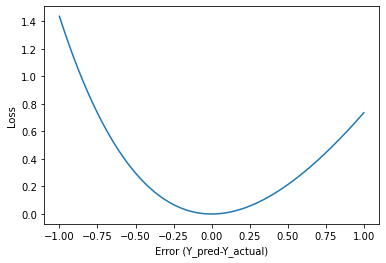

In [15]:
E = np.linspace(-1,1, 1000)
LINEX_loss = lambda E, a: (2/a**2)*(np.exp(a*E) - a*E - 1)
plt.plot(E, LINEX_loss(E, a= -1))
plt.xlabel('Error (Y_pred-Y_actual)')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

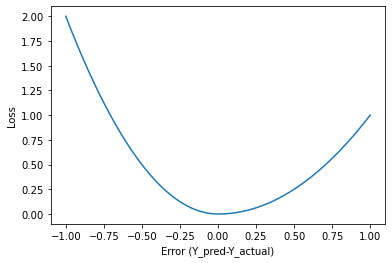

In [16]:
ASSYM_loss = lambda E : np.where((E)<0, 2*(E**2), (E**2))
plt.plot(E, ASSYM_loss(E))
plt.xlabel('Error (Y_pred-Y_actual)')
plt.ylabel('Loss')

In [17]:
"""Sources : 
1. https://arxiv.org/pdf/1603.02754.pdf 
2. https://github.com/froukje/articles/blob/main/02_custom_loss_xgboost.ipynb
3. https://www.datatrigger.org/post/asymmetric_loss/ 
"""
# def mean_bias_error(y_pred, y_true) :

def xgb_model(X_train, y_train,X_val, y_val, 
              objective='reg:squarederror',
              learning_rate=0.3,
              min_child_weight=1,
              lambda_=1,
              gamma=0, model_ckhpt_path='model_xgboost.json'):
    
    # Initialize XGB with objective function
    parameters = {"objective": objective,
              "n_estimators": 100,
              "eta": learning_rate,
              "lambda": lambda_,
              "gamma": gamma,
              "max_depth": None,
              "min_child_weight": min_child_weight,
              "verbosity": 0}

    
    model = xgb.XGBRegressor(**parameters)
    model.fit(X_train, y_train)
    model.save_model(model_ckhpt_path)
     
    # generate predictions
    y_pred_train = model.predict(X_train).reshape(-1,1)
    y_pred = model.predict(X_val).reshape(-1,1)
    
    # calculate errors
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_val = mean_squared_error(y_pred, y_val, squared=False)
    print(f"rmse training: {rmse_train:.3f}\t rmse validation: {rmse_val:.3f}")
    
    # plot results
    y_train = np.array(y_train).reshape(-1,1)
    y_val = np.array(y_val).reshape(-1,1)
    
    # y_train_dummy = y_train
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].scatter(y_pred_train, y_train, alpha=0.5, s=10)
    axes[0].plot(y_train, y_train, 'r')
    axes[0].set_xlabel('predicted values')
    axes[0].set_ylabel('true values')
    axes[0].set_title(f"Training, rmse: {rmse_train:.3f}")
    axes[1].scatter(y_pred, y_val, alpha=0.5, s=10)
    axes[1].plot(y_val, y_val, 'r')
    axes[1].set_xlabel('predicted values')
    axes[1].set_ylabel('true values')
    axes[1].set_title(f"Validation, rmse: {rmse_val:.3f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    frequency, bins = np.histogram(y_train, bins=50, range=[np.min(y_pred_train), np.max(y_pred_train)])
    axes[0].hist(y_train, alpha=0.5, bins=bins, density='true', label="train")
    axes[0].hist(y_pred_train, alpha=0.5, bins=bins, density='true', label="predictions")
    axes[0].set_xlabel('Label Scale (0-10)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f"Histogram of label distribution")
    axes[0].legend()
    axes[1].hist(y_val, alpha=0.5, bins=bins, density='true', label="validation")
    axes[1].hist(y_pred, alpha=0.5, bins=bins, density='true', label="prediction")
    axes[1].set_xlabel('Label Scale (0-10)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f"Histogram of label distribution")
    axes[1].legend()
    return y_pred_train, y_pred

In [18]:
def assym_loss_over_pred(y_val, y_pred):
    grad = np.where((y_val - y_pred)>0, -2.0*2.0*(y_val - y_pred), -2.0*(y_val - y_pred))
    hess = np.where((y_val - y_pred)>0, 2.0*2.0, 2.0)
    return grad, hess

def assym_loss_under_pred(y_val, y_pred):
    grad = np.where((y_val - y_pred)<0, -2.0*(y_val - y_pred), -2.0*2.0*(y_val - y_pred))
    hess = np.where((y_val - y_pred)<0, 2.0, 2.0*2.0)
    return grad, hess    

In [19]:
def __compute_mbe__(y_pred, y_test):
    mbe = np.zeros(len(y_test))
    for i in range(0, len(y_test)) :
        mbe[i] = y_pred[i] - y_test[i]
    print('MBE = ', np.mean(mbe))    
    return mbe   

In [20]:
def __compute_rel_predictions__(y_pred, y_test) :
    error = np.zeros(len(y_test))
    neg_error = 0
    pos_error = 0
    for i in range(0, len(y_test)) :
        error[i] = y_pred[i] - y_test[i]
        if error[i] < 0 :
            neg_error += 1 ## Under prediction --> more dangerous
        elif error[i] > 0 :
            pos_error += 1 ## Over prediction
    print('Underpredictions :', neg_error/len(y_test)) 
    print('Overpredictions :', pos_error/len(y_test)) 

In [21]:
def LinexLoss_over_pred(y_predicted, y_true):
    a = -0.5
    E = y_true - y_predicted
    grad = (2/a)*(np.exp(a*E) - 1)## negative of first derivative || Remember you are taking the derivative wrt y_pred
    hess = 2*(np.exp(a*E))
    # grad = 4*E**3
    # hess = 12*E**2
    return grad, hess

def LinexLoss_under_pred(y_predicted, y_true):
    a = 1
    E = y_true - y_predicted
    grad = (2/a)*(np.exp(a*E) - 1)## negative of first derivative || Remember you are taking the derivative wrt y_pred
    hess = 2*(np.exp(a*E))
    # grad = 4*E**3
    # hess = 12*E**2
    return grad, hess    

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.397	 rmse validation: 2.841


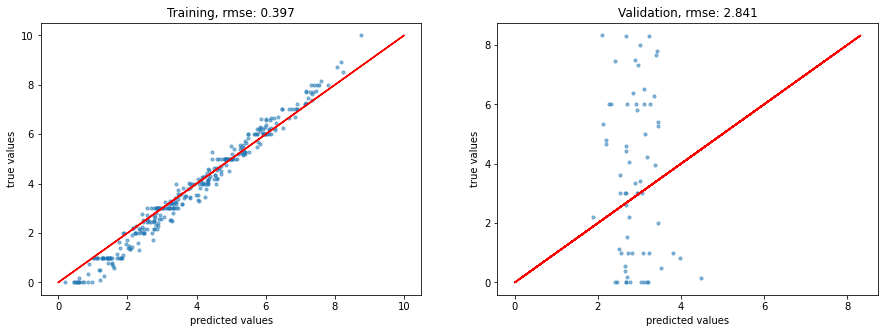

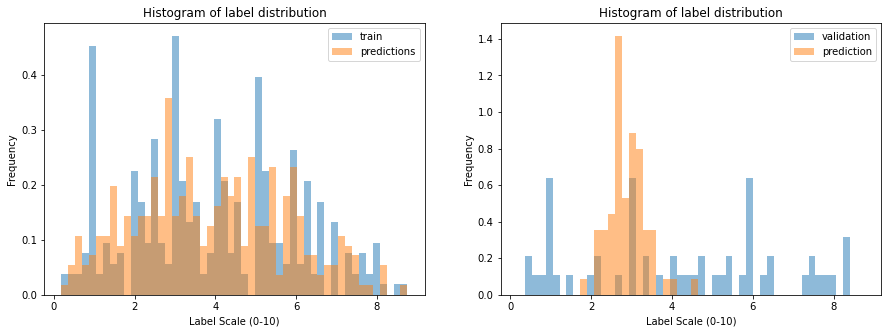

In [22]:
_, y_pred_over_assym = xgb_model(X_train, Y_train, X_test, Y_test, objective=assym_loss_over_pred, learning_rate=0.1, gamma=5, model_ckhpt_path='composite_assym.txt')
## higher the gamma --> more regularization

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.328	 rmse validation: 2.616


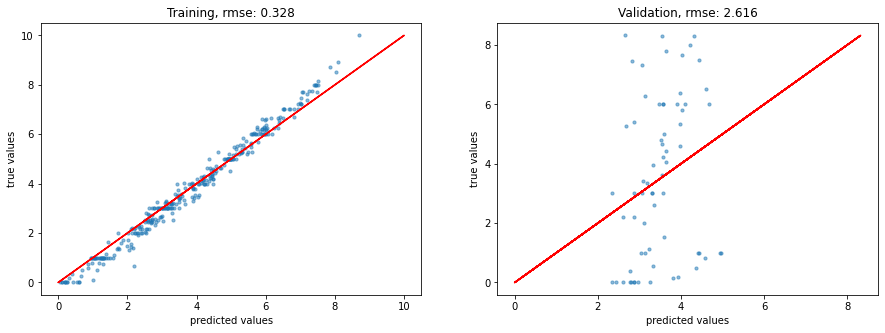

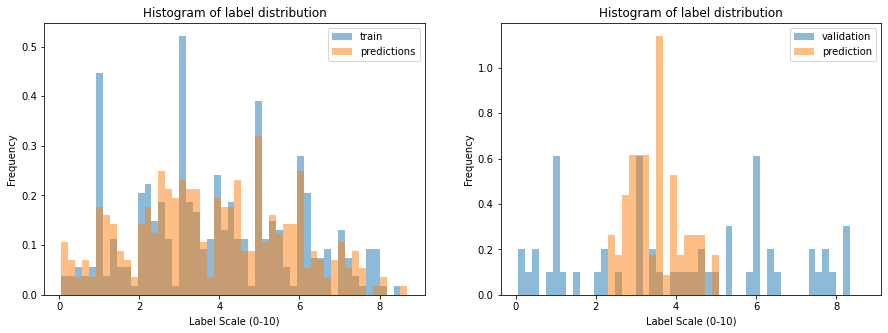

In [23]:
_, y_pred_over_linex = xgb_model(X_train, Y_train, X_test, Y_test, objective=LinexLoss_over_pred, learning_rate=0.1, gamma=2, model_ckhpt_path="composite_linex.txt")

rmse training: 0.304	 rmse validation: 2.948


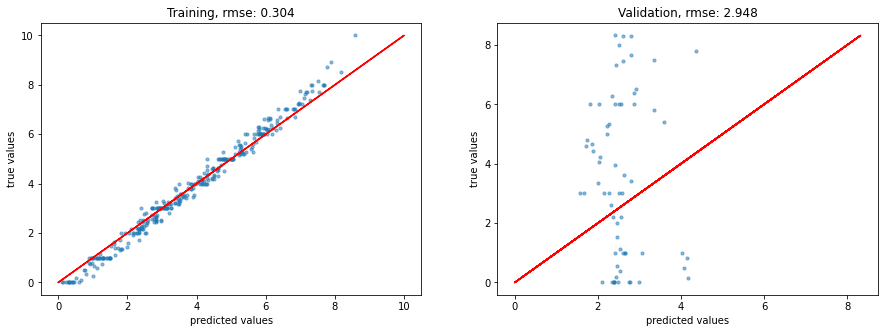

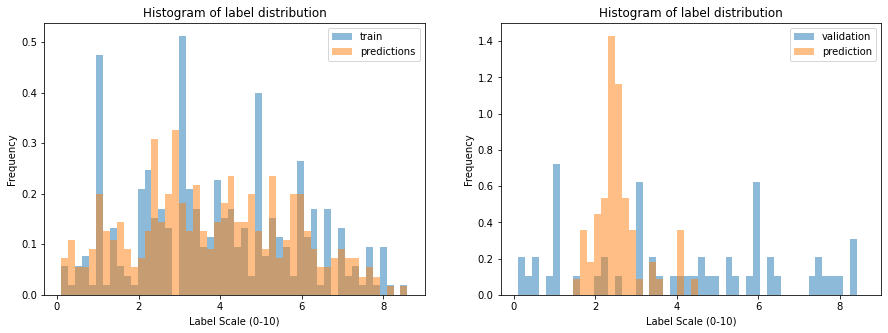

In [24]:
_, y_pred_mse = xgb_model(X_train, Y_train, X_test, Y_test, objective='reg:squarederror', learning_rate=0.1, gamma=1)

## Train ziptie

In [25]:
## Update Novemebr 14 :: Use fixed test set for all tasks
X_train = df_scaled_ziptie.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_train = ziptie_main_dataframe['final_fatigue'] ## Used non-scaled version for target

X_test = df_scaled_ziptie_test.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_test = ziptie_main_dataframe_test['final_fatigue']

In [26]:
len(X_train.columns)

47

In [27]:

X_train_zp, X_test_zp, Y_train_zp, Y_test_zp = sklearn.model_selection.train_test_split(
    df_scaled_ziptie.drop(['final_fatigue', 'init_fatigue'], axis='columns'), ziptie_main_dataframe['final_fatigue'], test_size=0.3)

X_train_zp = X_train_zp.to_numpy()
Y_train_zp = Y_train_zp.to_numpy()

X_test_zp  = X_test_zp.to_numpy()
Y_test_zp  = Y_test_zp.to_numpy()

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.538	 rmse validation: 1.462


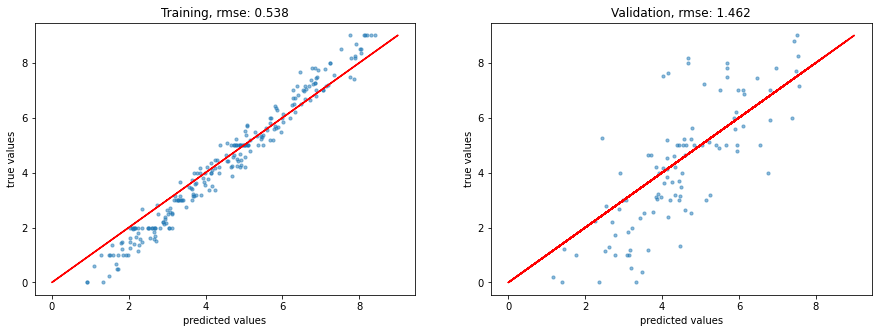

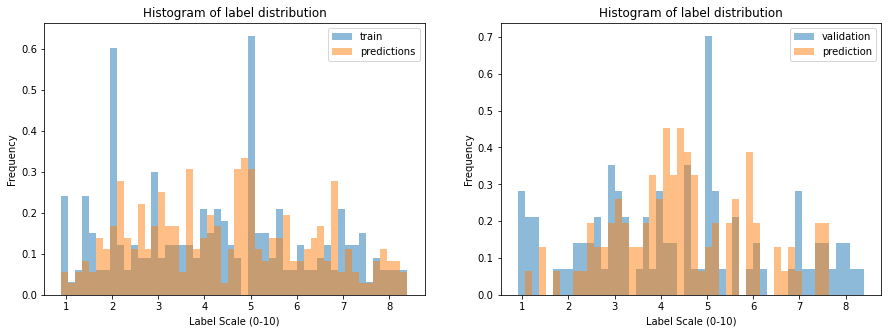

In [28]:
_, y_pred_over_assym_zp = xgb_model(X_train_zp, Y_train_zp, X_test_zp, Y_test_zp, objective=assym_loss_over_pred, learning_rate=0.1, gamma=10, model_ckhpt_path='ziptie_assym.txt')

rmse training: 0.890	 rmse validation: 1.600


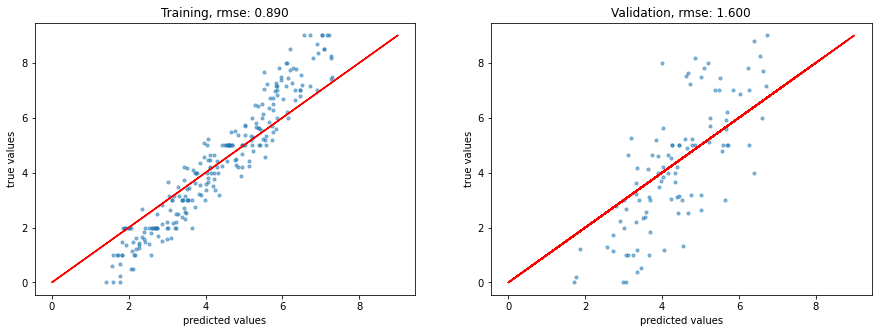

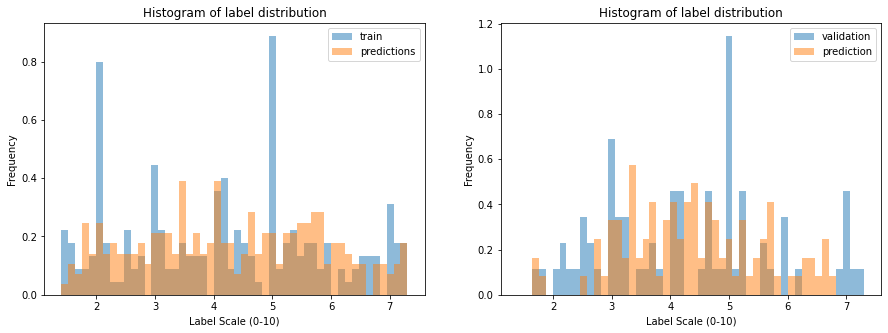

In [29]:
_, y_pred_over_mse_zp = xgb_model(X_train_zp, Y_train_zp, X_test_zp, Y_test_zp, objective='reg:squarederror', learning_rate=0.05, gamma=10)

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.677	 rmse validation: 1.423


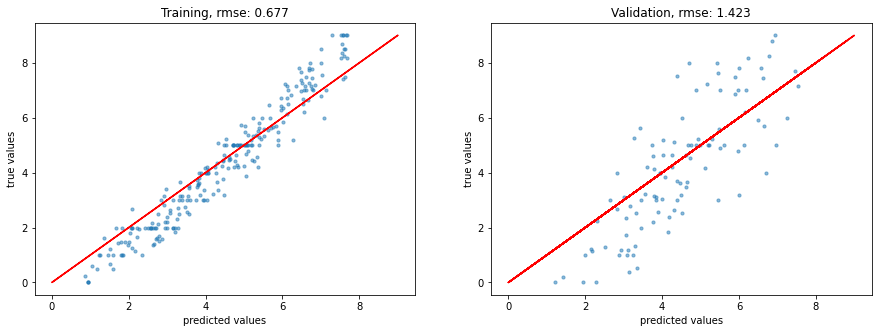

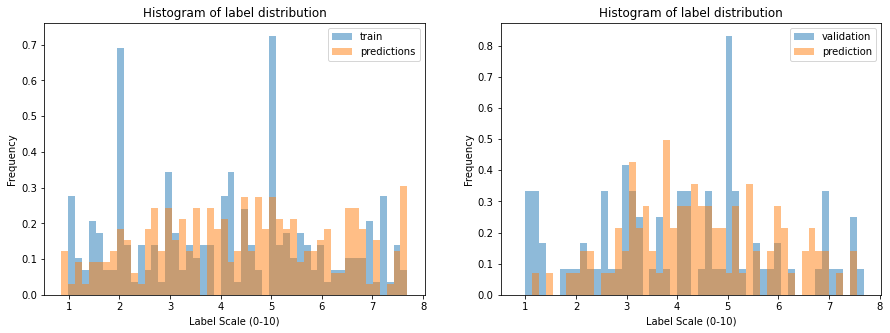

In [30]:
_, y_pred_over_linex_zp = xgb_model(X_train_zp, Y_train_zp, X_test_zp, Y_test_zp, objective=LinexLoss_over_pred, learning_rate=0.1, gamma=10, model_ckhpt_path='ziptie_linex.txt')

In [31]:
__compute_mbe__(y_pred_over_assym_zp, Y_test_zp)
__compute_rel_predictions__(y_pred_over_assym_zp, Y_test_zp)

MBE =  0.2636030362647714
Underpredictions : 0.4174757281553398
Overpredictions : 0.5825242718446602


## Combined Tasks

In [32]:
## Update Novemebr 14 :: Use fixed test set for all tasks
X_train_combo = df_scaled_combined.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_train_combo = combined_dataframe['final_fatigue'] ## Used non-scaled version for target

X_test_combo = df_scaled_combined_test.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_test_combo = combined_dataframe_test['final_fatigue']

In [33]:
X_train_combo.columns

Index(['avg_hr', 'del_hr', 'median_hr', 'std_hr', 'skew_hr', 'kurt_hr',
       'max_hr', 'cardiac_capacity', 'avg_hrv', 'del_hrv', 'median_hrv',
       'std_hrv', 'skew_hrv', 'kurt_hrv', 'max_hrv', 'avg_temp', 'max_temp',
       'del_temp', 'std_temp', 'rms_acc_imu1', 'rms_imu1_vel', 'rms_imu1_gyro',
       'range_gyro_imu1', 'ldlj_jerk_1', 'rms_acc_imu2', 'rms_imu2_vel',
       'rms_imu2_gyro', 'range_gyro_imu2', 'ldlj_jerk_2', 'rms_acc_imu3',
       'rms_imu3_vel', 'rms_imu3_gyro', 'range_gyro_imu3', 'ldlj_jerk_3',
       'rms_acc_imu4', 'rms_imu4_vel', 'rms_imu4_gyro', 'range_gyro_imu4',
       'ldlj_jerk_4', 'rms_acc_imu5', 'rms_imu5_vel', 'rms_imu5_gyro',
       'kinetic_expense', 'age', 'height', 'weight', 'gender'],
      dtype='object')

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.559	 rmse validation: 2.890


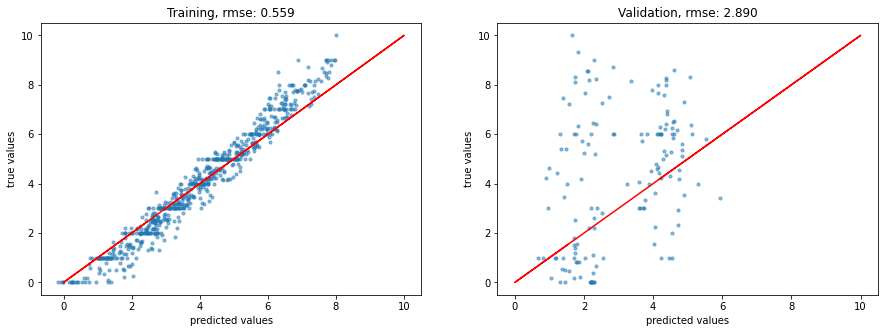

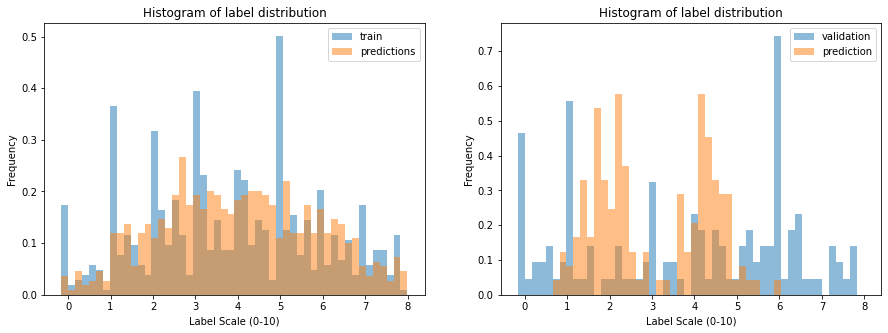

In [34]:
_, y_pred_over_linex_combo = xgb_model(X_train_combo, Y_train_combo, X_test_combo, Y_test_combo, objective=LinexLoss_over_pred, learning_rate=0.05, gamma=2, model_ckhpt_path="combined_linex.txt")

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.386	 rmse validation: 2.768


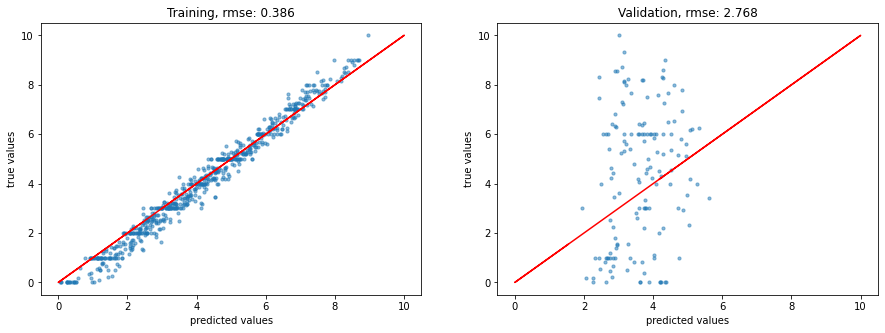

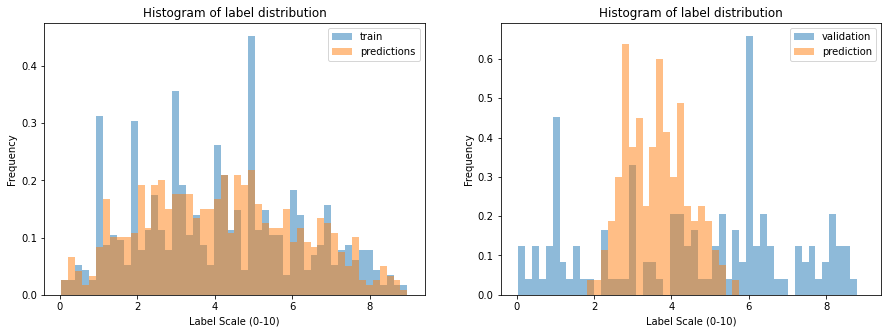

In [35]:
_, y_pred_over_assym_combo = xgb_model(X_train_combo, Y_train_combo, X_test_combo, Y_test_combo, objective=assym_loss_over_pred, learning_rate=0.1, gamma=3, model_ckhpt_path='combined_assym.txt')

In [38]:
np.shape(X_train_combo)

(669, 47)

rmse training: 0.830	 rmse validation: 2.636


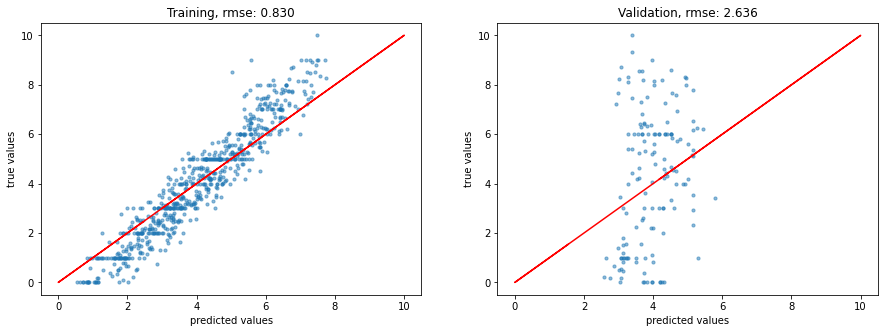

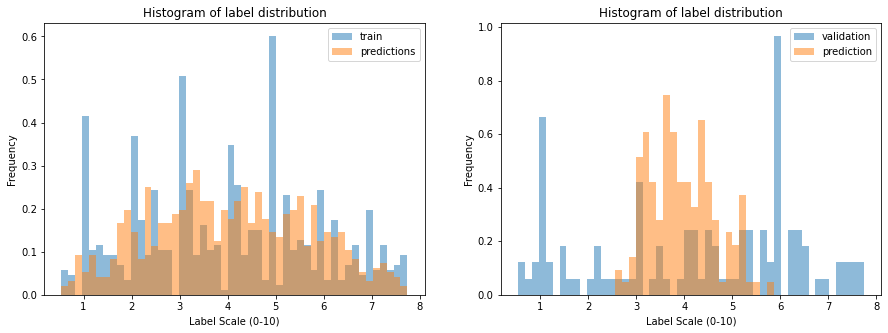

In [37]:
_, y_pred_over_mse_combo = xgb_model(X_train_combo, Y_train_combo, X_test_combo, Y_test_combo, objective='reg:squarederror', learning_rate=0.1, gamma=10)

## Combined dataframe only vitals

In [ ]:
df_scaled_combined_vitals = df_scaled_combined.drop(['rms_acc_imu1',
 'rms_imu1_vel',
 'rms_imu1_gyro',
 'range_gyro_imu1',
 'ldlj_jerk_1',
 'rms_acc_imu2',
 'rms_imu2_vel',
 'rms_imu2_gyro',
 'range_gyro_imu2',
 'ldlj_jerk_2',
 'rms_acc_imu3',
 'rms_imu3_vel',
 'rms_imu3_gyro',
 'range_gyro_imu3',
 'ldlj_jerk_3',
 'rms_acc_imu4',
 'rms_imu4_vel',
 'rms_imu4_gyro',
 'range_gyro_imu4',
 'ldlj_jerk_4',
 'rms_acc_imu5',
 'rms_imu5_vel',
 'rms_imu5_gyro',
 'kinetic_expense'], axis=1)

df_scaled_combined_vitals_test = df_scaled_combined_test.drop(['rms_acc_imu1',
 'rms_imu1_vel',
 'rms_imu1_gyro',
 'range_gyro_imu1',
 'ldlj_jerk_1',
 'rms_acc_imu2',
 'rms_imu2_vel',
 'rms_imu2_gyro',
 'range_gyro_imu2',
 'ldlj_jerk_2',
 'rms_acc_imu3',
 'rms_imu3_vel',
 'rms_imu3_gyro',
 'range_gyro_imu3',
 'ldlj_jerk_3',
 'rms_acc_imu4',
 'rms_imu4_vel',
 'rms_imu4_gyro',
 'range_gyro_imu4',
 'ldlj_jerk_4',
 'rms_acc_imu5',
 'rms_imu5_vel',
 'rms_imu5_gyro',
 'kinetic_expense'], axis=1)

In [ ]:
## Update Novemebr 14 :: Use fixed test set for all tasks
X_train_combo = df_scaled_combined_vitals.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_train_combo = combined_dataframe['final_fatigue'] ## Used non-scaled version for target

X_test_combo = df_scaled_combined_vitals_test.drop(['final_fatigue', 'init_fatigue'], axis='columns')
Y_test_combo = combined_dataframe_test['final_fatigue']

In [ ]:
X_train_combo, X_test_combo, Y_train_combo, Y_test_combo = sklearn.model_selection.train_test_split(
    df_scaled_combined_vitals.drop(['final_fatigue', 'init_fatigue'], axis='columns'), df_scaled_combined_vitals['final_fatigue'], test_size=0.3)

X_train_combo = X_train_combo.to_numpy()
Y_train_combo = Y_train_combo.to_numpy()

X_test_combo  = X_test_combo.to_numpy()
Y_test_combo  = Y_test_combo.to_numpy()

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.583	 rmse validation: 1.417


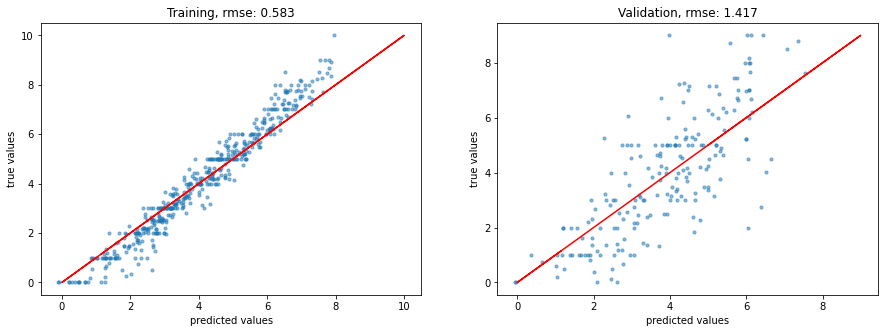

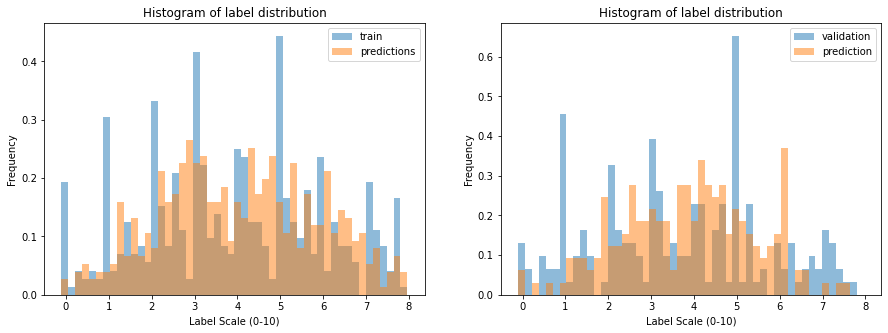

In [ ]:
_, y_pred_over_linex_combo = xgb_model(X_train_combo, Y_train_combo, X_test_combo, Y_test_combo, objective=LinexLoss_over_pred, learning_rate=0.05, gamma=2, model_ckhpt_path='combined_vitals_linex.txt')

/home/payal/miniconda3/envs/wav2vec/lib/python3.9/site-packages/xgboost/sklearn.py:722: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


rmse training: 0.315	 rmse validation: 1.516


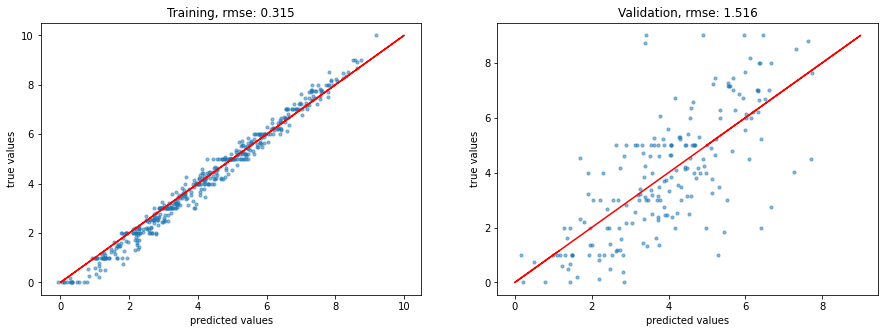

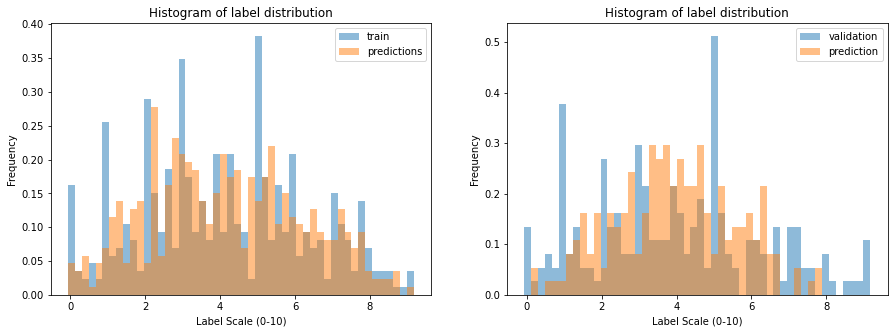

In [ ]:
_, y_pred_over_assym_combo = xgb_model(X_train_combo, Y_train_combo, X_test_combo, Y_test_combo, objective=assym_loss_over_pred, learning_rate=0.1, gamma=2, model_ckhpt_path='combined_vitals_assym.txt')

rmse training: 0.975	 rmse validation: 1.515


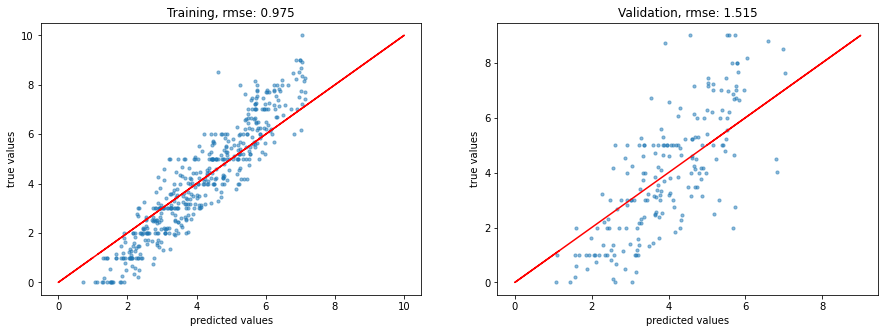

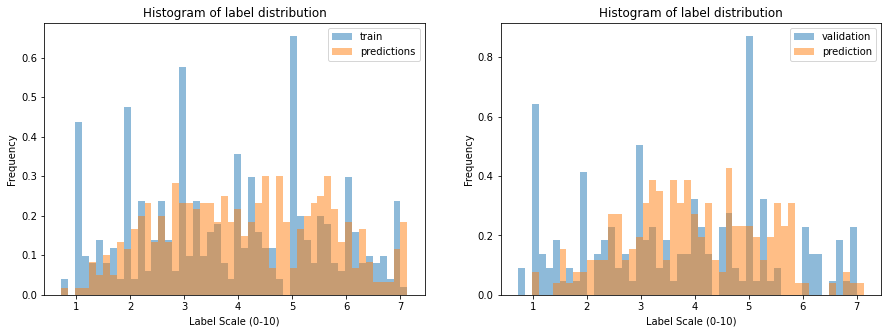

In [ ]:
_, y_pred_over_mse_combo = xgb_model(X_train_combo, Y_train_combo, X_test_combo, Y_test_combo, objective='reg:squarederror', learning_rate=0.1, gamma=10)